In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import skimage.io as skio
import torch.optim as optim
import skimage as sk
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from torch.optim.lr_scheduler import StepLR

In [3]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data = np.load(f"lego_200x200.npz")
images_train = data["images_train"] / 255.0
c2ws_train = data["c2ws_train"]
images_val = data["images_val"] / 255.0
c2ws_val = data["c2ws_val"]
c2ws_test = data["c2ws_test"]
focal = data["focal"]

In [5]:
height = 200
width = 200
n_samples = 32

In [6]:
K = np.array([[focal,0,width/2],[0,focal,height/2],[0,0,1]])

In [7]:
def transform(c2w, x_c):
    #camera to world
    num_rows = len(x_c)
    ones_column = np.ones((num_rows, 1))
    x_c_with_one = np.concatenate((x_c, ones_column), axis=1)
    x = (c2w @ x_c_with_one.T).T
    return x[:,:-1]

In [8]:
def pixel_to_camera(K, uv,s):
    num_rows = len(uv)
    ones_column = np.ones((num_rows, 1))
    uv_with_one = np.concatenate((uv, ones_column), axis=1)
    result = (np.linalg.inv(K) @ uv_with_one.T).T
    return result

In [9]:
def pixel_to_ray(K, c2w, uv):
    zeros = np.array([[0,0,0]])
    origin = transform(c2w, zeros)
    depth_1_points = pixel_to_camera(K, uv, 1)
    world_depth_1_points = transform(c2w, depth_1_points)
    world_depth_1_points_direction = world_depth_1_points - origin
    norms = np.linalg.norm(world_depth_1_points_direction, axis=1, keepdims=True)
    directions = world_depth_1_points_direction/ norms

    return origin, directions

In [10]:
class RaysData(Dataset):
    def __init__(self, img_train, K, c2ws_train):
        self.img = img_train
        self.c2ws = c2ws_train
        self.K = K
        self.height = 200
        self.width = 200
        self.length = len(self.img) * self.height * self.width

    def __len__(self):
        return len(self.img) * self.height * self.width
    
    def __getitem__(self, idx):
        img_index = idx // (self.width*self.height)
        residual = idx % (self.width*self.height)
        temp_height = residual // self.height 
        temp_width = residual % self.width 
        c2w = self.c2ws[img_index]
        uv = np.array([[temp_height+0.5, temp_width+0.5]])
        ray_o, ray_d = pixel_to_ray(self.K, c2w, uv)
        pixel = self.img[img_index,temp_height,temp_width,:]
        sample = {'rays_o':ray_o[0],
                  "rays_d":ray_d[0],
                 "pixels":pixel}
        return sample

    def generate_sample_pool(self):
        self.rays_o = []
        self.rays_d = []
        self.pixels = []
        for index in range(self.__len__()):
            img_index = index // (self.width*self.height)
            residual = index % (self.width*self.height)
            temp_height = residual // self.height 
            temp_width = residual % self.width 
            c2w = self.c2ws[img_index]
            uv = np.array([[temp_height+0.5, temp_width+0.5]])
            ray_o, ray_d = pixel_to_ray(self.K, c2w, uv)
            self.rays_o.append(ray_o[0])
            self.rays_d.append(ray_d[0])
            self.pixels.append(self.img[img_index,temp_height,temp_width,:])
        self.rays_o = np.array(self.rays_o)
        self.rays_d = np.array(self.rays_d)
        self.pixels = np.array(self.pixels)
            
    # def sample_rays(self, num_samples):
    #     rays_o = []
    #     rays_d = []
    #     pixels = []
    #     # random_numbers = [random.randint(0,self.length -1) for _ in range(num_samples)]
    #     random_numbers = np.random.randint(0, self.length - 1, size=num_samples) 
    #     for random_number in random_numbers:
    #         img_index = random_number // (self.width*self.height)
    #         residual = random_number % (self.width*self.height)
    #         temp_height = residual // self.height 
    #         temp_width = residual % self.width 
    #         c2w = self.c2ws[img_index]
    #         uv = np.array([[temp_height+0.5, temp_width+0.5]])
    #         ray_o, ray_d = pixel_to_ray(self.K, c2w, uv)
    #         rays_o.append(ray_o[0])
    #         rays_d.append(ray_d[0])
    #         pixels.append(self.img[img_index,temp_height,temp_width,:])
    #     return rays_o, rays_d,pixels


    # def generate(self):
    #     for i in range(eval_height):
    #     uv = []
    #     for j in range(eval_width):
    #         uv.append([i,j])
    #     ray_o, ray_d = pixel_to_ray(K, c2w_eval, uv)
    #     rays_o = np.repeat(ray_o, eval_height, axis=0)
    #     rays_d = list(ray_d)
    
    #     rays_o = torch.tensor(rays_o).float().to(device)
    #     rays_d = torch.tensor(rays_d).float().to(device)
    
    def sample_rays(self, num_samples):
        # rays_o = []
        # rays_d = []
        # pixels = []
        # # random_numbers = [random.randint(0,self.length -1) for _ in range(num_samples)]
        random_numbers = np.random.randint(0, self.length - 1, size=num_samples) 
        # for random_number in random_numbers:
        #     img_index = random_number // (self.width*self.height)
        #     residual = random_number % (self.width*self.height)
        #     temp_height = residual // self.height 
        #     temp_width = residual % self.width 
        #     c2w = self.c2ws[img_index]
        #     uv = np.array([[temp_height+0.5, temp_width+0.5]])
        #     ray_o, ray_d = pixel_to_ray(self.K, c2w, uv)
        #     rays_o.append(ray_o[0])
        #     rays_d.append(ray_d[0])
        #     pixels.append(self.img[img_index,temp_height,temp_width,:])
        return self.rays_o[random_numbers], self.rays_d[random_numbers], self.pixels[random_numbers]

In [11]:
# aaa =   torch.ones(100, 32) * torch.rand(1)*(6 - 2 )/ n_samples 

In [11]:
# aaa

In [11]:
def sample_along_rays(rays_o, rays_d, n_samples=32, perturb=True):
    far = 6 
    near = 2
    
    t_values = torch.linspace(near, far, n_samples).to(device)
    # ran_values = (torch.rand((len(rays_o), n_samples)) * (far - near) / n_samples).to(device)
    ran_values = torch.ones(len(rays_o), n_samples) * torch.rand(1)*(far - near) / n_samples 
    ran_values = ran_values.to(device)
    # Create 3D grid for rays_o and rays_d
    ray_o_grid = rays_o[:, None, :].repeat(1, n_samples, 1)
    ray_d_grid = rays_d[:, None, :].repeat(1, n_samples, 1)

    # Compute points without explicit loops
    if perturb:
        p_t = t_values + ran_values
    else:
        p_t = t_values + ran_values*0
    p_t = p_t.to(device)
    points = ray_o_grid + ray_d_grid * p_t.unsqueeze(2)

    return points.view(-1, 3)

In [33]:
# dataset = RaysData(images_train, K, c2ws_train)
# dataloader = DataLoader(dataset, batch_size=100,
#                         shuffle=True)

In [34]:
# data_iterator = iter(dataloader)
# one_batch = next(data_iterator)
# rays_o, rays_d, pixels = one_batch

# rays_o = one_batch['rays_o'].squeeze()
# rays_d = one_batch['rays_d'].squeeze()
# rays_o = rays_o.float()
# rays_d = rays_d.float()

In [35]:
# import viser, time  # pip install viser
# import numpy as np

# # --- You Need to Implement These ------
# dataset = RaysData(images_train, K, c2ws_train)
# dataloader = DataLoader(dataset, batch_size=100,
#                         shuffle=True)
# data_iterator = iter(dataloader)
# one_batch = next(data_iterator)
# rays_o, rays_d, pixels = one_batch

# rays_o = one_batch['rays_o'].squeeze()
# rays_d = one_batch['rays_d'].squeeze()
# rays_o = rays_o.float().to(device)
# rays_d = rays_d.float().to(device)
# points = sample_along_rays(rays_o, rays_d, perturb=True)
# H, W = images_train.shape[1:3]

In [36]:
# points = points.detach().cpu().numpy()
# rays_o = rays_o.detach().cpu().numpy()
# rays_d = rays_d.detach().cpu().numpy()

In [37]:
# server = viser.ViserServer(share=True)
# for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
#     server.add_camera_frustum(
#         f"/cameras/{i}",
#         fov=2 * np.arctan2(H / 2, K[0, 0]),
#         aspect=W / H,
#         scale=0.15,
#         wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
#         position=c2w[:3, 3],
#         image=image
#     )
# for i, (o, d) in enumerate(zip(rays_o, rays_d)):
#     server.add_spline_catmull_rom(
#         f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
#     )
# server.add_point_cloud(
#     f"/samples",
#     colors=np.zeros_like(points).reshape(-1, 3),
#     points=points.reshape(-1, 3),
#     point_size=0.02,
# )
# time.sleep(1000)

(viser) Share URL requested! (expires in 24 hours)

╭───────────────────────── viser ─────────────────────────╮
│             ╷                                           │
│   HTTP      │ http://0.0.0.0:8082                       │
│   Websocket │ ws://0.0.0.0:8082                         │
│   Share URL │ https://shadow-cheap.share.viser.studio   │
│             ╵                                           │
╰─────────────────────────────────────────────────────────╯

(viser) Connection closed (0, 0 total)

(viser) Connection opened (0, 1 total), 506 persistent messages

(viser) Connection closed (0, 0 total)

KeyboardInterrupt: 

In [12]:
def volrend(sigmas, rgbs, step_size):
    sigmas = sigmas.to(device)
    rgbs = rgbs.to(device)
    size_to_prepend = (sigmas.size(0), 1, 1)

    zeros_to_prepend = torch.zeros(size_to_prepend, dtype=sigmas.dtype).to(device)
    
    tensor_with_zeros = torch.cat((zeros_to_prepend, sigmas), dim=1).to(device)

    
    
    cum_sigmas = torch.cumsum(tensor_with_zeros,dim=1)[:,:-1].to(device)
    T = torch.exp(-cum_sigmas*step_size).to(device)
    interval_sigmas = 1 - torch.exp(-sigmas*step_size).to(device)
    weights = T * interval_sigmas
    colors = rgbs * weights
    cum_colors = torch.sum(colors, dim=1).to(device)

    return cum_colors

In [13]:
class Residual_block(nn.Module):
    def __init__(self, dim):
        super(Residual_block, self).__init__()
        self.dim = dim
        self.linear_1 = nn.Linear(dim, dim)
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=dim)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(dim, dim)
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=dim)
        nn.init.kaiming_normal_(self.linear_1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.linear_2.weight, mode='fan_in', nonlinearity='relu')

    def forward(self,x):
        origin_x = x
        x = self.linear_1(x)
        x = self.layer_norm_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.layer_norm_2(x)
        x = self.relu(x + origin_x)
        return x

In [14]:
class Nerf_model(nn.Module):
    def __init__(self,high_fre_level, high_fre_level_angle, hidden_dim):
        super(Nerf_model, self).__init__()
        self.high_fre_level = high_fre_level
        self.high_fre_level_angle = high_fre_level_angle
        self.pe_dim = 3+high_fre_level*6
        self.pe_dim_angle = 3 + 6 * high_fre_level_angle
        self.input_layer = nn.Linear(3+high_fre_level*6, hidden_dim)
        self.residual_block_1 = Residual_block(hidden_dim)
        self.residual_block_2 = Residual_block(hidden_dim)
        self.residual_block_3 = Residual_block(hidden_dim)
        
        self.hidden_layer_1 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_layer_2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.hidden_layer_concat_angle = nn.Linear(hidden_dim + self.pe_dim_angle, hidden_dim//2)

        nn.init.kaiming_normal_(self.hidden_layer_concat_angle.weight, mode='fan_in', nonlinearity='relu')
        
        self.out = nn.Linear(hidden_dim//2, 3)
        nn.init.kaiming_normal_(self.out.weight, mode='fan_in', nonlinearity='relu')
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.density_layer = nn.Linear(hidden_dim, 1)

        power_terms_pos = (torch.exp2(torch.arange(0, high_fre_level))*3.14159).to(device)
        
        power_terms_angle = (torch.exp2(torch.arange(0, high_fre_level_angle))*3.14159).to(device)
        
        self.power_matrix_pos= torch.zeros(3, self.high_fre_level *3).to(device)
        for i in range(3):
            self.power_matrix_pos[i,i*high_fre_level:(i+1)*high_fre_level] = power_terms_pos

        self.power_matrix_angle = torch.zeros(3, self.high_fre_level_angle  *3).to(device)
        for i in range(3):
            self.power_matrix_angle[i,i*high_fre_level_angle :(i+1)*high_fre_level_angle ] = power_terms_angle


        self.middle_layer_norm = nn.LayerNorm(normalized_shape=hidden_dim) 
        
        self.last_layer_norm = nn.LayerNorm(normalized_shape=hidden_dim//2) 

    def positional_encoding(self, data, high_fre_level, power_matrix):

        powered_data = data @ power_matrix
        sin_matrix = torch.sin(powered_data).to(device)
        cos_matrix = torch.cos(powered_data).to(device)

        pe = torch.cat((data, sin_matrix, cos_matrix),1).to(device)

        return pe

    def forward(self,pos, angle):
                
        pos_pe = self.positional_encoding(pos, self.high_fre_level, self.power_matrix_pos)
        
        origin_x = pos_pe
        x = self.input_layer(origin_x)
        x = self.residual_block_1(x)
        x = self.residual_block_2(x)
        x = self.residual_block_3(x)
        x = self.hidden_layer_1(x)
        sigmas = self.density_layer(x)
        sigmas = self.relu(sigmas)

        # x = self.middle_layer_norm(x)
        x = self.hidden_layer_2(x)

        angle_pe = self.positional_encoding(angle, self.high_fre_level_angle, self.power_matrix_angle)
        # angle_input = torch.cat((angle,angle_pe),dim=1)
        concated_x = torch.cat((x,angle_pe), dim = 1).float()
        x = self.hidden_layer_concat_angle(concated_x)
        x = self.last_layer_norm(x)
        x = self.relu(x)
        x = self.out(x)
        x = self.sigmoid(x)
        return x, sigmas

In [14]:
# class Nerf_model(nn.Module):
#     def __init__(self,high_fre_level, high_fre_level_angle, hidden_dim):
#         super(Nerf_model, self).__init__()
#         self.high_fre_level = high_fre_level
#         self.high_fre_level_angle = high_fre_level_angle
#         self.pe_dim = 3+high_fre_level*6
#         self.pe_dim_angle = 3 + 6 * high_fre_level_angle
#         self.input_layer = nn.Linear(3+high_fre_level*6, hidden_dim)
#         # self.input_layer = nn.Linear(2, hidden_dim)
#         hidden_layer_list = []


        
#         for i in range(3):
#             hidden_layer_list.append(nn.Linear(hidden_dim, hidden_dim))
#             hidden_layer_list.append(nn.ReLU())
#         self.hidden_layer_1 = nn.Sequential(*hidden_layer_list)

#         self.concat_hidden_layer = nn.Linear(hidden_dim + self.pe_dim,hidden_dim)
        
#         hidden_layer_list = []
#         for i in range(2):
#             hidden_layer_list.append(nn.Linear(hidden_dim, hidden_dim))
#             hidden_layer_list.append(nn.ReLU())
#         self.hidden_layer_2 = nn.Sequential(*hidden_layer_list)

#         self.hidden_layer_3 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_4 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_5 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_concat_angle = nn.Linear(hidden_dim + self.pe_dim_angle, hidden_dim//2)

#         self.out = nn.Linear(hidden_dim//2, 3)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()
#         self.density_layer = nn.Linear(hidden_dim, 1)
        
#         power_terms_pos = (torch.exp2(torch.arange(0, high_fre_level))*3.14159).to(device)
        
#         power_terms_angle = (torch.exp2(torch.arange(0, high_fre_level_angle))*3.14159).to(device)
        
#         self.power_matrix_pos= torch.zeros(3, self.high_fre_level *3).to(device)
#         for i in range(3):
#             self.power_matrix_pos[i,i*high_fre_level:(i+1)*high_fre_level] = power_terms_pos

#         self.power_matrix_angle = torch.zeros(3, self.high_fre_level_angle  *3).to(device)
#         for i in range(3):
#             self.power_matrix_angle[i,i*high_fre_level_angle :(i+1)*high_fre_level_angle ] = power_terms_angle

#         # self.layer_norm1 = nn.LayerNorm(normalized_shape=HIDDEN_UNITS)  
#         # self._initialize_weights()
#         self.last_layer_norm = nn.LayerNorm(normalized_shape=hidden_dim//2) 
        

#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)


    


#     def positional_encoding(self, data, high_fre_level, power_matrix):

#         powered_data = data @ power_matrix
#         sin_matrix = torch.sin(powered_data).to(device)
#         cos_matrix = torch.cos(powered_data).to(device)

#         pe = torch.cat((data, sin_matrix, cos_matrix),1).to(device)

#         return pe




    
#     def forward_phase_1(self, origin_x):

#         x = self.input_layer(origin_x)
#         x = self.relu(x)
#         x = self.hidden_layer_1(x)
#         x = torch.cat((x,origin_x), dim = 1)
#         x = self.concat_hidden_layer(x)
#         x = self.relu(x)
#         x = self.hidden_layer_2(x)
#         x = self.hidden_layer_3(x)
#         return x


        
#     def forward(self, pos, angle):
        
#         pos_pe = self.positional_encoding(pos, self.high_fre_level, self.power_matrix_pos)
        
#         origin_x = pos_pe
#         x = self.forward_phase_1(origin_x)




        
#         sigmas = self.density_layer(x)
#         sigmas = self.relu(sigmas)
        
#         x = self.hidden_layer_4(x)
#         angle_pe = self.positional_encoding(angle, self.high_fre_level_angle, self.power_matrix_angle)
#         # angle_input = torch.cat((angle,angle_pe),dim=1)
#         concated_x = torch.cat((x,angle_pe), dim = 1).float()
#         x = self.hidden_layer_concat_angle(concated_x)
#         x = self.last_layer_norm(x)
#         x = self.relu(x)
#         x = self.out(x)
#         x = self.sigmoid(x)
#         return x, sigmas
        

In [15]:
def calcualte_PSNR():
    model.eval()
    loss_fn = nn.SmoothL1Loss(reduction='sum')
    dataset = RaysData(images_val, K, c2ws_val)
    dataloader = DataLoader(dataset, batch_size=10000,
                        shuffle=True)
    loss = 0
    for i_batch, sample_batched in enumerate(tqdm(dataloader)):
        # print(len(sample_batched['pixels']))
        # rays_o, rays_d, pixels = dataset.sample_rays(10000)
        # rays_o, rays_d, pixels = dataset.sample_rays_one(1000)
        # t1 = time.time()
        rays_o = sample_batched['rays_o'].squeeze()
        rays_d = sample_batched['rays_d'].squeeze()
        pixels = sample_batched['pixels']
        rays_o = rays_o.float().to(device)
        rays_d = rays_d.float().to(device)
        # rays_d = np.array(rays_d)
        # rays_o = np.array(rays_o)
        # rays_d = torch.tensor(rays_d).to(device)
        # rays_o = torch.tensor(rays_o).to(device)
        points = sample_along_rays(rays_o, rays_d)
        
    
        points = points.float().to(device)
        # points = np.array(points)
        # rays_d = np.array(rays_d)
        # points = torch.tensor(points).to(device)
        # rays_d = torch.tensor(rays_d).to(device)
    
        rays_d = torch.unsqueeze(rays_d,1)
        rays_d = rays_d.repeat(1,n_samples,1)
        rays_d = rays_d.view(-1,3)
        
        # t2 = time.time()
        # print('p',t2-t1)
        # t1 = t2
        
        rgbs, sigmas = model(points, rays_d)
        
        # t2 = time.time()
        # print('forward',t2-t1)
        # t1 = t2
        
        rgbs = rgbs.to(device)
        sigmas = sigmas.to(device)
        # sigams = model.foward_dentisy()
        sigmas = sigmas.view(-1, n_samples, 1)
        rgbs = rgbs.view(-1, n_samples, 3)
        
    
    
        rendered_colors = volrend(sigmas, rgbs, step_size)

                
        # t2 = time.time()
        # print('render',t2-t1)
        # t1 = t2
        # print("render",rendered_colors[0])
        # print("pixels",pixels[0])
    
        pixels = pixels.float().to(device)

        with torch.no_grad():
            loss += loss_fn(rendered_colors, pixels)
    return loss.item()/len(dataset)

In [16]:
model = Nerf_model(30,10,256).to(device)
step_size = (6-2)/n_samples

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [19]:
PSNR_loss_list = []

global_iter = 0

In [21]:
dataset = RaysData(images_train, K, c2ws_train)
dataset.generate_sample_pool()
# rays_o, rays_d, pixels = dataset.sample_rays(10)

In [22]:
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# criterion = PSNRWithMSELoss()
criterion = torch.nn.MSELoss()
number_epoch  = 3
model.train()
# scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
# for i in range(number_iteration):

# dataset = RaysData(images_train, K, c2ws_train)
# dataloader = DataLoader(dataset, batch_size=10000,
#                         shuffle=True)

for e in range(number_epoch):
#     for i_batch, sample_batched in enumerate(tqdm(dataloader)):
    for i in tqdm(range(1000)):
        # print(len(sample_batched['pixels']))
        rays_o, rays_d, pixels = dataset.sample_rays(10000)
        # rays_o, rays_d, pixels = dataset.sample_rays_one(1000)
        # t1 = time.time()
        
        # rays_o = sample_batched['rays_o'].squeeze()
        # rays_d = sample_batched['rays_d'].squeeze()
        # pixels = sample_batched['pixels']
        # rays_o = rays_o.float().to(device)
        # rays_d = rays_d.float().to(device)

        
        # rays_d = np.array(rays_d)
        # rays_o = np.array(rays_o)
        rays_d = torch.tensor(rays_d).float().to(device)
        rays_o = torch.tensor(rays_o).float().to(device)
        points = sample_along_rays(rays_o, rays_d, perturb=False)
        
    
        points = points.float().to(device)
        # points = np.array(points)
        # rays_d = np.array(rays_d)
        # points = torch.tensor(points).to(device)
        # rays_d = torch.tensor(rays_d).to(device)
    
        rays_d = torch.unsqueeze(rays_d,1)
        rays_d = rays_d.repeat(1,n_samples,1)
        rays_d = rays_d.view(-1,3)
        
        # t2 = time.time()
        # print('p',t2-t1)
        # t1 = t2
        
        rgbs, sigmas = model(points, rays_d)
        
        # t2 = time.time()
        # print('forward',t2-t1)
        # t1 = t2
        
        rgbs = rgbs.to(device)
        sigmas = sigmas.to(device)
        # sigams = model.foward_dentisy()
        sigmas = sigmas.view(-1, n_samples, 1)
        rgbs = rgbs.view(-1, n_samples, 3)
        
    
    
        rendered_colors = volrend(sigmas, rgbs, step_size)

                
        # t2 = time.time()
        # print('render',t2-t1)
        # t1 = t2
        # print("render",rendered_colors[0])
        # print("pixels",pixels[0])
    
        # pixels = pixels.float().to(device)
        # pixels = np.array(pixels)
        pixels = torch.tensor(pixels).float().to(device)
    
        # print(rendered_colors)
        loss = criterion(rendered_colors, pixels)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

                        
        # t2 = time.time()
        # print('backward',t2-t1)
        # t1 = t2
        # scheduler.step()
        # if global_iter % 100 ==0:
        #     PSNR_loss_list.append(calcualte_PSNR())
        #     print(PSNR_loss_list[-1])
        global_iter += 1
        if global_iter % 49 == 0:
            print(f'iteration [{i}], Loss: {loss.item()}')
    # scheduler.step()
    # torch.save(model.state_dict(), 'weights_%s.pth'%e)

  5%|██                                       | 50/1000 [00:15<04:51,  3.26it/s]

iteration [48], Loss: 0.06421259790658951


 10%|████                                     | 99/1000 [00:31<04:42,  3.19it/s]

iteration [97], Loss: 0.0590556263923645


 15%|█████▉                                  | 148/1000 [00:48<04:28,  3.17it/s]

iteration [146], Loss: 0.0541895255446434


 20%|███████▉                                | 197/1000 [01:03<04:02,  3.31it/s]

iteration [195], Loss: 0.04370306804776192


 25%|█████████▊                              | 246/1000 [01:19<03:48,  3.29it/s]

iteration [244], Loss: 0.04294086992740631


 30%|███████████▊                            | 295/1000 [01:35<03:34,  3.29it/s]

iteration [293], Loss: 0.041407790035009384


 34%|█████████████▊                          | 344/1000 [01:51<03:19,  3.29it/s]

iteration [342], Loss: 0.042379867285490036


 39%|███████████████▋                        | 393/1000 [02:07<03:05,  3.28it/s]

iteration [391], Loss: 0.04250291362404823


 44%|█████████████████▋                      | 442/1000 [02:22<02:50,  3.28it/s]

iteration [440], Loss: 0.040392495691776276


 49%|███████████████████▋                    | 491/1000 [02:38<02:35,  3.27it/s]

iteration [489], Loss: 0.0405411534011364


 54%|█████████████████████▌                  | 540/1000 [02:54<02:20,  3.28it/s]

iteration [538], Loss: 0.039548635482788086


 59%|███████████████████████▌                | 589/1000 [03:10<02:05,  3.27it/s]

iteration [587], Loss: 0.04002143070101738


 64%|█████████████████████████▌              | 638/1000 [03:26<01:50,  3.27it/s]

iteration [636], Loss: 0.03906799480319023


 69%|███████████████████████████▍            | 687/1000 [03:41<01:35,  3.26it/s]

iteration [685], Loss: 0.03913789615035057


 74%|█████████████████████████████▍          | 736/1000 [03:58<01:22,  3.21it/s]

iteration [734], Loss: 0.037255462259054184


 78%|███████████████████████████████▍        | 785/1000 [04:13<01:05,  3.28it/s]

iteration [783], Loss: 0.03946570307016373


 83%|█████████████████████████████████▎      | 834/1000 [04:30<00:51,  3.24it/s]

iteration [832], Loss: 0.03822194039821625


 88%|███████████████████████████████████▎    | 883/1000 [04:45<00:35,  3.26it/s]

iteration [881], Loss: 0.03631450980901718


 93%|█████████████████████████████████████▎  | 932/1000 [05:01<00:20,  3.24it/s]

iteration [930], Loss: 0.03694479167461395


 98%|███████████████████████████████████████▏| 981/1000 [05:17<00:05,  3.22it/s]

iteration [979], Loss: 0.0355677604675293


  3%|█▏                                       | 30/1000 [00:09<05:08,  3.14it/s]

iteration [28], Loss: 0.03475749492645264


  8%|███▏                                     | 79/1000 [00:26<04:43,  3.24it/s]

iteration [77], Loss: 0.034159883856773376


 13%|█████                                   | 128/1000 [00:42<04:26,  3.27it/s]

iteration [126], Loss: 0.0347088947892189


 18%|███████                                 | 177/1000 [00:58<04:13,  3.25it/s]

iteration [175], Loss: 0.0333060696721077


 23%|█████████                               | 226/1000 [01:15<04:09,  3.10it/s]

iteration [224], Loss: 0.032286398112773895


 28%|███████████                             | 275/1000 [01:31<03:56,  3.06it/s]

iteration [273], Loss: 0.03214891627430916


 32%|████████████▉                           | 324/1000 [01:47<03:33,  3.16it/s]

iteration [322], Loss: 0.03126027062535286


 37%|██████████████▉                         | 373/1000 [02:03<03:12,  3.26it/s]

iteration [371], Loss: 0.03140300512313843


 42%|████████████████▉                       | 422/1000 [02:19<02:57,  3.26it/s]

iteration [420], Loss: 0.030146965757012367


 47%|██████████████████▊                     | 471/1000 [02:35<02:41,  3.27it/s]

iteration [469], Loss: 0.03032868541777134


 52%|████████████████████▊                   | 520/1000 [02:51<02:28,  3.23it/s]

iteration [518], Loss: 0.029607271775603294


 57%|██████████████████████▊                 | 569/1000 [03:07<02:12,  3.25it/s]

iteration [567], Loss: 0.029518645256757736


 62%|████████████████████████▋               | 618/1000 [03:23<01:57,  3.24it/s]

iteration [616], Loss: 0.02946488745510578


 67%|██████████████████████████▋             | 667/1000 [03:39<01:42,  3.25it/s]

iteration [665], Loss: 0.02838665246963501


 72%|████████████████████████████▋           | 716/1000 [03:55<01:27,  3.25it/s]

iteration [714], Loss: 0.02798527479171753


 76%|██████████████████████████████▌         | 765/1000 [04:11<01:12,  3.25it/s]

iteration [763], Loss: 0.02744726836681366


 81%|████████████████████████████████▌       | 814/1000 [04:27<00:57,  3.25it/s]

iteration [812], Loss: 0.027034234255552292


 86%|██████████████████████████████████▌     | 863/1000 [04:43<00:44,  3.09it/s]

iteration [861], Loss: 0.026404304429888725


 91%|████████████████████████████████████▍   | 912/1000 [05:00<00:28,  3.08it/s]

iteration [910], Loss: 0.026531318202614784


 96%|██████████████████████████████████████▍ | 961/1000 [05:16<00:12,  3.14it/s]

iteration [959], Loss: 0.025527337566018105


  1%|▍                                        | 10/1000 [00:03<05:06,  3.23it/s]

iteration [8], Loss: 0.02548896335065365


  6%|██▍                                      | 59/1000 [00:20<04:49,  3.25it/s]

iteration [57], Loss: 0.024980396032333374


 11%|████▎                                   | 108/1000 [00:37<04:52,  3.04it/s]

iteration [106], Loss: 0.02387489378452301


 16%|██████▎                                 | 157/1000 [00:53<04:28,  3.14it/s]

iteration [155], Loss: 0.023855777457356453


 21%|████████▏                               | 206/1000 [01:10<04:30,  2.94it/s]

iteration [204], Loss: 0.0234523992985487


 26%|██████████▏                             | 255/1000 [01:27<04:12,  2.94it/s]

iteration [253], Loss: 0.02294745109975338


 30%|████████████▏                           | 304/1000 [01:45<03:47,  3.06it/s]

iteration [302], Loss: 0.023479003459215164


 35%|██████████████                          | 353/1000 [02:01<03:28,  3.10it/s]

iteration [351], Loss: 0.02299926057457924


 40%|████████████████                        | 402/1000 [02:18<03:18,  3.02it/s]

iteration [400], Loss: 0.02354530058801174


 45%|██████████████████                      | 451/1000 [02:35<02:55,  3.13it/s]

iteration [449], Loss: 0.022347595542669296


 50%|████████████████████                    | 500/1000 [02:52<02:43,  3.06it/s]

iteration [498], Loss: 0.022277845069766045


 55%|█████████████████████▉                  | 549/1000 [03:09<02:29,  3.02it/s]

iteration [547], Loss: 0.022117625921964645


 60%|███████████████████████▉                | 598/1000 [03:26<02:10,  3.08it/s]

iteration [596], Loss: 0.02132331021130085


 65%|█████████████████████████▉              | 647/1000 [03:43<01:58,  2.99it/s]

iteration [645], Loss: 0.021765153855085373


 70%|███████████████████████████▊            | 696/1000 [04:01<01:40,  3.01it/s]

iteration [694], Loss: 0.021270310506224632


 74%|█████████████████████████████▊          | 745/1000 [04:18<01:22,  3.09it/s]

iteration [743], Loss: 0.022230135276913643


 79%|███████████████████████████████▊        | 794/1000 [04:34<01:06,  3.09it/s]

iteration [792], Loss: 0.021340424194931984


 84%|█████████████████████████████████▋      | 843/1000 [04:51<00:51,  3.05it/s]

iteration [841], Loss: 0.02087154984474182


 89%|███████████████████████████████████▋    | 892/1000 [05:08<00:34,  3.10it/s]

iteration [890], Loss: 0.01995309442281723


 94%|█████████████████████████████████████▋  | 941/1000 [05:25<00:19,  3.07it/s]

iteration [939], Loss: 0.02017907239496708


 99%|███████████████████████████████████████▌| 990/1000 [05:42<00:03,  3.10it/s]

iteration [988], Loss: 0.020038964226841927


100%|███████████████████████████████████████| 1000/1000 [05:45<00:00,  2.89it/s]


In [23]:
torch.save(model.state_dict(), 'weights_arc3.pth')

In [19]:
weights_path = 'weights_5.pth'  # Provide the correct path to the saved weights file
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [ ]:
400: 
1200 = 0.1287

In [27]:
model.eval()
eval_height = 200
eval_width = 200
# c2w_eval = c2ws_train[6]
c2w_eval = c2ws_test[0]
results = np.zeros((eval_height, eval_width,3))
for i in range(eval_height):
    uv = []
    for j in range(eval_width):
        uv.append([i+0.5,j+0.5])
    ray_o, ray_d = pixel_to_ray(K, c2w_eval, uv)
    rays_o = np.repeat(ray_o, eval_height, axis=0)
    rays_d = list(ray_d)

    rays_o = torch.tensor(rays_o).float().to(device)
    rays_d = torch.tensor(rays_d).float().to(device)
    points = sample_along_rays(rays_o, rays_d, perturb=False)
    points = points.to(device)
    # rays_d = torch.tensor(rays_d).to(device)
    rays_d = torch.unsqueeze(rays_d,1)
    rays_d = rays_d.repeat(1,n_samples,1)
    rays_d = rays_d.view(-1,3)
    
    rgbs, sigmas = model(points, rays_d)
    rgbs = rgbs.to(device)
    sigmas = sigmas.to(device)
    # sigams = model.foward_dentisy()
    sigmas = sigmas.view(-1, n_samples, 1)
    rgbs = rgbs.view(-1, n_samples, 3)
    
    rendered_colors = volrend(sigmas, rgbs, step_size).detach().cpu().numpy()

    # print(rendered_colors.shape)
    results[i,:,:] = rendered_colors

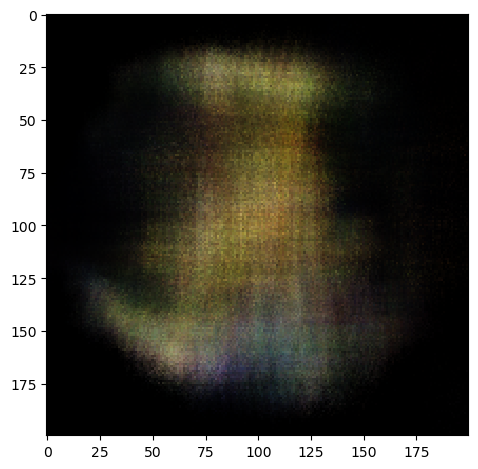

In [28]:

skio.imshow(results)
# skio.imsave("r_5000.jpg",results)

In [26]:
for index in range(len(c2ws_test)):
    print("saving: ", index)
    model.eval()
    eval_height = 200
    eval_width = 200
    # c2w_eval = c2ws_train[2]
    c2w_eval = c2ws_test[index]
    results = np.zeros((eval_height, eval_width,3))
    for i in range(eval_height):
        uv = []
        for j in range(eval_width):
            uv.append([i,j])
        ray_o, ray_d = pixel_to_ray(K, c2w_eval, uv)
        rays_o = np.repeat(ray_o, eval_height, axis=0)
        rays_d = list(ray_d)
    
        rays_o = torch.tensor(rays_o).float().to(device)
        rays_d = torch.tensor(rays_d).float().to(device)
        points = sample_along_rays(rays_o, rays_d, perturb=False)
        points = points.to(device)
        # rays_d = torch.tensor(rays_d).to(device)
        rays_d = torch.unsqueeze(rays_d,1)
        rays_d = rays_d.repeat(1,n_samples,1)
        rays_d = rays_d.view(-1,3)
        
        rgbs, sigmas = model(points, rays_d)
        rgbs = rgbs.to(device)
        sigmas = sigmas.to(device)
        # sigams = model.foward_dentisy()
        sigmas = sigmas.view(-1, n_samples, 1)
        rgbs = rgbs.view(-1, n_samples, 3)
        
        rendered_colors = volrend(sigmas, rgbs, step_size).detach().cpu().numpy()
    
        # print(rendered_colors.shape)
        results[i,:,:] = rendered_colors
    save_file_path = 'test_results/%s.png'%index  # Change the file extension as needed (e.g., .jpg, .png, .bmp, etc.)

    # Save the NumPy array as an image using skimage
    skio.imsave(save_file_path, results)

saving:  0


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  1


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  2


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  3


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  4


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  5


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  6


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  7


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  8


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  9


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  10


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  11


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  12


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  13


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  14


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  15


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  16


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  17


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  18


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  19


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  20


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  21


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  22


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  23


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  24


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  25


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  26


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  27


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  28


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  29


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  30


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  31


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  32


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  33


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  34


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  35


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  36


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  37


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  38


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  39


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  40


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  41


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  42


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  43


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  44


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  45


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  46


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  47


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  48


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  49


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  50


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  51


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  52


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  53


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  54


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  55


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  56


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  57


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  58


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  59


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
